In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

import tensorflow.keras.backend as K
import tensorflow as tf

import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import os
import tensorflow as tf
import keras as keras
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import src.proprietary_functions as src

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist

In [2]:
#list of samples strings
list_samples = ['train','valid','test']
#dictionary for storing cropped images, image names and labels
arr_dicts = {}

In [3]:
#importing numpy objects of cropped images
for sampl in list_samples:
    with open(f'./cropped_numpys/cropped_{sampl}_X.npy', 'rb') as f:
        arr_dicts[f'arr_{sampl}_X']  = np.load(f)

arr_train_X = arr_dicts['arr_train_X']
arr_valid_X = arr_dicts['arr_valid_X']
arr_test_X = arr_dicts['arr_test_X']

In [4]:
#importing numpy objects of image names
for sampl in list_samples:
    with open(f'./cropped_numpys/cropped_{sampl}_X_names.npy', 'rb') as f:
        arr_dicts[f'{sampl}_X_names']  = np.load(f)

train_X_names = arr_dicts['train_X_names']
valid_X_names = arr_dicts['valid_X_names']
test_X_names = arr_dicts['test_X_names']

In [5]:
#importing numpy objects of labels
for sampl in list_samples:
    with open(f'./cropped_numpys/cropped_{sampl}_Y.npy', 'rb') as f:
        arr_dicts[f'arr_{sampl}_Y']  = np.load(f)

arr_train_Y = arr_dicts['arr_train_Y']
arr_valid_Y = arr_dicts['arr_valid_Y']
arr_test_Y = arr_dicts['arr_test_Y']

In [6]:
#function for creation of triplets
def	make_triplets(images, labels, image_names):

	tripletImages = []
	tripletImagesNames = []
	uniqueClasses = np.unique(labels)

	dict_idx = {i:np.where(labels == i)[0] for i in uniqueClasses}

	for idxA in range(len(images)):

		#current image
		currentImage = images[idxA]
		label = labels[idxA]
		currentImage_name = image_names[idxA]

		#positive image
		idxB = np.random.choice(dict_idx[label])
		posImage = images[idxB]
		posImage_name = image_names[idxB]

		#negative image
		negLab = np.random.choice([i for i in dict_idx.keys() if i != label])
		negIdx = np.random.choice(dict_idx[negLab])
		negImage = images[negIdx]
		negImage_name = image_names[negIdx]
        
		#saving the triplets of images and image names
		tripletImages.append([currentImage, posImage, negImage])
		tripletImagesNames.append([currentImage_name, posImage_name, negImage_name])

	return (np.array(tripletImages), np.array(tripletImagesNames))

In [8]:
train_X_triplets, train_triplets_names= make_triplets(arr_train_X, arr_train_Y, train_X_names)
valid_X_triplets, valid_triplets_names = make_triplets(arr_valid_X, arr_valid_Y, valid_X_names)
test_X_triplets, test_triplets_names = make_triplets(arr_test_X, arr_test_Y, test_X_names)

In [14]:
if not os.path.exists('./triplet_numpys/'):
    os.makedirs('./triplet_numpys/')

In [13]:
dict_triplets = {'train': {'triplet_imgs': train_X_triplets, 'triplet_imgs_names':train_triplets_names},
                'valid': {'triplet_imgs': valid_X_triplets,'triplet_imgs_names':valid_triplets_names},
                'test': {'triplet_imgs': test_X_triplets, 'triplet_imgs_names':test_triplets_names}}

In [15]:
#exporting the triplets of images and image names as numpy objects.
for sampl in dict_triplets.keys():
    for n in dict_triplets[sampl].keys():
       with open(f'./triplet_numpys/{sampl}_{n}.npy', 'wb') as f:
            np.save(f, dict_triplets[sampl][n])

NN model building with triplet loss

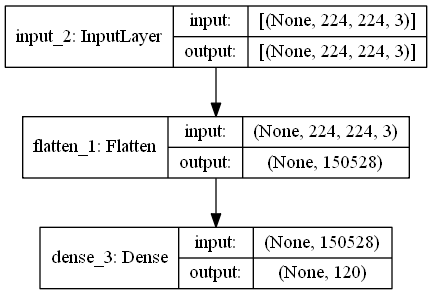

In [35]:
def initialize_base_network():
    input = Input(shape=(224,224,3))
    x = Flatten()(input)
    x = Dense(120, activation='relu')(x)
    return Model(inputs=input, outputs=x)

embedding = initialize_base_network()
tf.keras.utils.plot_model(embedding, show_shapes=True)

In [19]:
class SiameseNet(tf.keras.layers.Layer):
    # set the backbone model in constructor
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, feat):
        # get feature vectors from anchor
        feats = self.model(feat[0])
        # from positive image
        pfeats = self.model(feat[1])
        # and from negative image
        nfeats = self.model(feat[2])
        # concatenate vectors to a matrix
        result = tf.stack([feats, pfeats, nfeats])
        return result

class TripletLoss(tf.keras.layers.Layer):
    # margin is settable hyperparameter in constructor
    def __init__(self, margin):
        self.margin = margin
        super().__init__()
        
    # function calculating distance between features
    def distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

    def call(self, features):
        # get anchor-positive distance
        pos = self.distance(features[0], features[1])
        # anchor-negative distance
        neg = self.distance(features[0], features[2])
        # difference between anchor positive and anchor negative distances
        loss = pos - neg
        # get overall loss
        return tf.maximum(loss + self.margin, 0.0)

In [20]:
# anchor branch
image_input = Input(shape=(224,224,3), name='image_input')
# positive image branch
positive_input = Input(shape=(224,224,3), name='positive_input')
# negative image branch
negative_input = Input(shape=(224,224,3), name='negative_input')

In [39]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(abs(y_true-y_pred))

In [40]:
siamese = SiameseNet(embedding)([image_input, positive_input, negative_input])
loss = TripletLoss(margin=1.0)(siamese)
model = Model(inputs=[image_input, positive_input, negative_input], outputs=loss)
model.compile(optimizer ='adam', loss = identity_loss)

In [41]:
history = model.fit([train_X_triplets[:,0], train_X_triplets[:,1], train_X_triplets[:,2]], np.ones(train_X_triplets.shape[0]),
                verbose=1,
            validation_data=([valid_X_triplets[:,0], valid_X_triplets[:,1], valid_X_triplets[:,2]], np.ones(valid_X_triplets.shape[0])),
            epochs=10)

MemoryError: Unable to allocate 861. MiB for an array with shape (6000, 224, 224, 3) and data type uint8

In [ ]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()

	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend()
	plt.show()


	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()

In [ ]:
plot_training(history)

Predictions